In [1]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.7).
The following additional packages will be installed:
  libegl-dev libgl-dev libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev
  libglvnd-core-dev libglvnd-dev libglx-dev libopengl-dev libosmesa6
The following NEW packages will be installed:
  libegl-dev libgl-dev libgl1-mesa-dev libgl1-mesa-glx libgles-dev libgles1
  libglew-dev libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev
  libglx-dev libopengl-dev libosmesa6 libosmesa6-dev
0 upgraded, 15 newly installed, 0 to remove and 18 not upgraded.
Need to get 3,952 kB of archives.
After this operation, 18.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgl-dev amd64 1.4.0-1 [101 kB]
Get:3 http://archive.ubuntu.com/ubuntu 

In [2]:
!pip3 install gymnasium
# !pip install swig
!pip install gymnasium[mujoco]
#!pip install -U 'mujoco-py<2.2,>=2.1'
!pip install free-mujoco-py


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 21.9 MB/s eta 0:00:00
  Attempting uninstall: glfw
    Found existing installation: glfw 2.6.2
    Uninstalling glfw-2.6.2:
      Successfully uninstalled glfw-2.6.2
  Attempting uninstall: Cython
    Found existing installation: Cython 3.0.2
    Uninstalling Cython-3.0.2:
      Successfully uninstalled Cython-3.0.2


In [2]:
import gymnasium as gym
import mujoco_py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from collections import deque
import random
import cv2

from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Working with {device}")

Working with cpu


In [7]:
class FCTQV(nn.Module):
    def __init__(self, input_dim, hidden_dims=(32, 32), activation_fc = nn.ReLU()):
        super(FCTQV, self).__init__()
        self.activation_fc = activation_fc
        self.layers_a = [(nn.Linear(input_dim, hidden_dims[0]))]
        self.layers_b = [(nn.Linear(input_dim, hidden_dims[0]))]

        for i in range(len(hidden_dims) - 1):
            self.layers_a.append(self.activation_fc)
            self.layers_a.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))

            self.layers_b.append(self.activation_fc)
            self.layers_b.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))

        self.layers_a.append(self.activation_fc)
        self.layers_a.append(nn.Linear(hidden_dims[-1], 1))

        self.layers_b.append(self.activation_fc)
        self.layers_b.append(nn.Linear(hidden_dims[-1], 1))

        self.layers_a = nn.Sequential(*self.layers_a)
        self.layers_b = nn.Sequential(*self.layers_b)

    def forward(self, state, action):
        x = state
        y = action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, dtype=torch.float32).unsqueeze(0).to(device)

        z = torch.cat((x, y), dim = 1).to(device).to(torch.float32)

        za = self.layers_a(z)
        zb = self.layers_b(z)
        return za, zb

    def Qa(self, state, action):
        x = state
        y = action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, dtype=torch.float32).unsqueeze(0).to(device)

        z = torch.cat((x, y), dim = 1).to(device).to(torch.float32)

        za = self.layers_a(z)
        return za

class FCDP(nn.Module):
    def __init__(self, input_dim, action_bounds, hidden_dims=(32, 32), activation_fc = nn.ReLU(), out_activation = nn.Tanh()):
        super(FCDP, self).__init__()
        self.env_min, self.env_max = torch.Tensor(action_bounds[0]).to(device), torch.Tensor(action_bounds[1]).to(device)
        self.activation_fc = activation_fc
        self.out_activation = out_activation
        self.layers = [(nn.Linear(input_dim, hidden_dims[0]))]

        for i in range(len(hidden_dims) - 1):
            self.layers.append(self.activation_fc)
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
        self.layers.append(self.activation_fc)
        self.layers.append(nn.Linear(hidden_dims[-1], len(self.env_max)))
        self.layers.append(self.out_activation)
        self.layers = nn.Sequential(*self.layers)


    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

        out = self.layers(x.to(torch.float32))

        return self.rescale(out)

    def rescale(self, out):
        return (out + 1)*(self.env_max - self.env_min) / (2) + self.env_min




In [8]:
class NormalNoiseDecayStrategy():
    def __init__(self, bounds, init_noise_ratio=0.5, min_noise_ratio=0.1, decay_steps=10000):
        self.t = 0
        self.low, self.high = bounds
        self.noise_ratio = init_noise_ratio
        self.init_noise_ratio = init_noise_ratio
        self.min_noise_ratio = min_noise_ratio
        self.decay_steps = decay_steps

    def _noise_ratio_update(self):
        noise_ratio = 1 - self.t / self.decay_steps
        noise_ratio = (self.init_noise_ratio - self.min_noise_ratio) * noise_ratio + self.min_noise_ratio
        noise_ratio = np.clip(noise_ratio, self.min_noise_ratio, self.init_noise_ratio)
        self.t += 1
        return noise_ratio

    def select_action(self, model, state, max_exploration=False):
        if max_exploration:
            noise_scale = self.high
        else:
            noise_scale = self.noise_ratio * self.high

        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()

        noise = np.random.normal(loc=0, scale=noise_scale, size=len(self.high))
        noisy_action = greedy_action + noise
        action = np.clip(noisy_action, self.low, self.high)

        self.noise_ratio = self._noise_ratio_update()
        return action

In [9]:
class ReplayBuffer:
    def __init__(self, max_len):
        self.experiences = deque(maxlen = max_len)

    def add_experience(self, state, action, reward, next_state, is_terminal):
        self.experiences.append((state, action, reward, next_state, is_terminal))

    def get_batch_experince(self, batch_size):
        batch = random.sample(self.experiences, batch_size)
        states = np.array([i[0] for i in batch])
        actions = np.array([i[1] for i in batch])
        rewards = np.array([i[2] for i in batch])
        next_states = np.array([i[3] for i in batch])
        is_terminals = np.array([i[4] for i in batch])
        return (tuple([states, actions, rewards, next_states, is_terminals]))


In [17]:
class TD3:
    def __init__(self, env, gamma, replay_buffer_size, batch_size, hidden_dims, policy_optimizer, value_optimizer, grad_clip, tau, update_steps, decay_steps, policy_noise_ratio, policy_noise_clip_ratio, policy_optimise_steps, lr = (1e-4, 1e-4)):
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.replaybuffer = ReplayBuffer(replay_buffer_size)
        self.batch_size = batch_size
        self.update_steps = update_steps
        self.decay_steps = decay_steps

        nS, nA = self.env.observation_space.shape[0], self.env.action_space.shape[0]
        action_bounds = self.env.action_space.low, self.env.action_space.high
        self.online_value_model = FCTQV(nS + nA, hidden_dims[0]).to(device)
        self.target_value_model = FCTQV(nS + nA, hidden_dims[0]).to(device)
        self.online_policy_model = FCDP(nS, action_bounds, hidden_dims[1]).to(device)
        self.target_policy_model = FCDP(nS, action_bounds, hidden_dims[1]).to(device)
        self.update_model(tau = 1.0)
        self.env.reset()

        self.value_optimizer = value_optimizer(self.online_value_model.parameters(), lr[0])
        self.policy_optimizer = policy_optimizer(self.online_policy_model.parameters(), lr[1])
        self.value_grad_clip, self.policy_grad_clip = grad_clip

        self.action_policy = NormalNoiseDecayStrategy(action_bounds, decay_steps = self.decay_steps)

        self.policy_noise_ratio = policy_noise_ratio
        self.policy_noise_clip_ratio = policy_noise_clip_ratio
        self.policy_optimise_steps = policy_optimise_steps

        self.returns = deque(maxlen = 100)

    def update_model(self, tau = None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_value_model.parameters(), self.online_value_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_policy_model.parameters(), self.online_policy_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def optimize_model(self, experiences, time_stamp):

        states, actions, rewards, next_states, is_terminals = experiences

        states = torch.from_numpy(states).to(device)
        actions = torch.from_numpy(actions).to(device)
        next_states = torch.from_numpy(next_states).to(device)
        rewards = torch.from_numpy(rewards).to(device).unsqueeze(0).T
        is_terminals = torch.from_numpy(is_terminals).to(device).unsqueeze(0).T

        with torch.no_grad():
            env_min = self.target_policy_model.env_min
            env_max = self.target_policy_model.env_max

            a_ran = env_max - env_min
            a_noise = torch.randn_like(actions)*self.policy_noise_ratio*a_ran

            n_min = env_min*self.policy_noise_clip_ratio
            n_max = env_max*self.policy_noise_clip_ratio

            a_noise = torch.maximum(torch.minimum(a_noise, n_max), n_min)

            argmax_a_q_sp = self.target_policy_model(next_states)
            noisy_argmax_a_q_sp = argmax_a_q_sp + a_noise
            noisy_argmax_a_q_sp = torch.maximum(torch.minimum(noisy_argmax_a_q_sp, env_max), env_min)

            max_a_q_sp_a, max_a_q_sp_b = self.target_value_model(next_states, argmax_a_q_sp)
            max_a_q_sp = torch.minimum(max_a_q_sp_a, max_a_q_sp_b)
            target_q_sa = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)


        q_sa_a, q_sa_b = self.online_value_model(states, actions)
        td_error_a = q_sa_a - target_q_sa
        td_error_b = q_sa_b - target_q_sa
        value_loss = td_error_a.pow(2).mul(0.5).mean() + td_error_b.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        nn.utils.clip_grad_norm_(self.online_value_model.parameters(), self.value_grad_clip)
        self.value_optimizer.step()

        if(time_stamp % self.policy_optimise_steps == 0):
            argmax_a_q_s = self.online_policy_model(states)
            max_a_q_s = self.online_value_model.Qa(states, argmax_a_q_s)
            policy_loss = -max_a_q_s.mean()
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            nn.utils.clip_grad_norm_(self.online_policy_model.parameters(), self.policy_grad_clip)
            self.policy_optimizer.step()

    def interactive_step(self, state):
        action = self.action_policy.select_action(self.target_policy_model, state)
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        self.replaybuffer.add_experience(state, action, reward, new_state, int(terminated and not truncated))
        return new_state, terminated or truncated

    def train(self, num_steps, step, evals, goal):
        epis = 1
        terminated = False
        state = self.env.reset()[0]
        for i in tqdm(range(1, num_steps + 1)):
            state, terminated = self.interactive_step(state)
            if(len(self.replaybuffer.experiences) > self.batch_size):
                self.optimize_model(self.replaybuffer.get_batch_experince(self.batch_size), i)
            if(terminated):
                epis += 1
                state = self.env.reset()[0]
                if(epis % step == 0):
                    if(self.evaluate(evals, goal)):
                        torch.save(self.target_policy_model.state_dict(), f'./target_policy.pth')
                        torch.save(self.target_value_model.state_dict(), f'./target_value.pth')
                        return
            if(num_steps % self.update_steps == 0):
                self.update_model()

    def evaluate(self, evals, goal):
        for _ in range(evals):
            state = self.env.reset()[0]
            terminated = False
            return_val = 0
            while(not terminated):
                img = self.env.render()
                cv2.imshow("Environment", img)
                cv2.waitKey(1)
                action = self.target_policy_model(state).detach().cpu()
                state, reward, terminate, truncated, _ = self.env.step(action[0].numpy())
                terminated = truncated or terminate
                return_val += reward
            cv2.destroyAllWindows()
            self.returns.append(return_val)

        _mean = np.mean(list(self.returns)[-evals:])
        print(f"\nMean return value of last {evals} evaluations = {_mean}")
        plt.plot(range(len(self.returns)), self.returns)
        plt.xlabel("Eval Episodes")
        plt.ylabel("Return Obtained")
        plt.show()
        return (goal <= _mean)
    
    def load_weights(self, value_file, policy_file):
        self.target_value_model.load_state_dict(torch.load(value_file, map_location=torch.device('cpu')))
        self.target_policy_model.load_state_dict(torch.load(policy_file, map_location=torch.device('cpu')))
    
    def show(self, num_epis):
        for _ in range(num_epis):
            state = self.env.reset()[0]
            terminated = False
            while(not terminated):
                img = self.env.render()
                cv2.imshow("Environment", img)
                cv2.waitKey(1)
                action = self.target_policy_model(state).detach().cpu()
                state, reward, terminate, truncated, _ = self.env.step(action[0].numpy())
                terminated = truncated or terminate
            cv2.destroyAllWindows()


  0%|          | 610/500000 [00:04<56:19, 147.75it/s]


Mean return value of last 10 evaluations = -1.3357442392981635


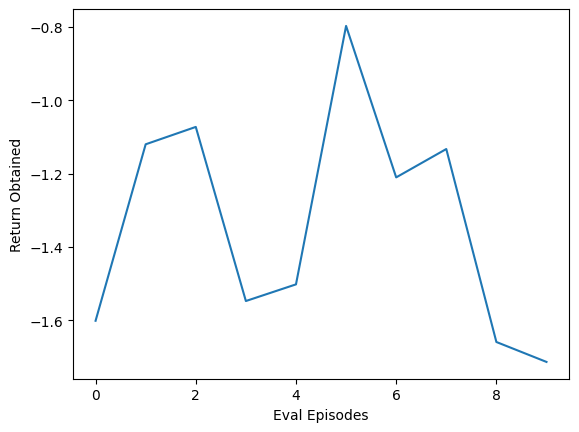

  0%|          | 1509/500000 [00:11<58:50, 141.20it/s]


Mean return value of last 10 evaluations = 54.77627369268648


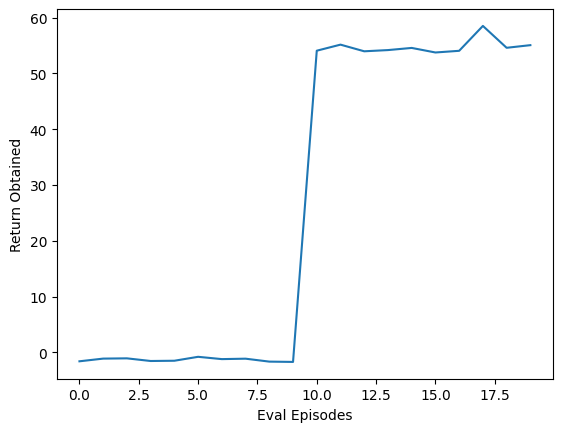

  1%|          | 3651/500000 [00:27<57:55, 142.81it/s]


Mean return value of last 10 evaluations = 175.95806797002055


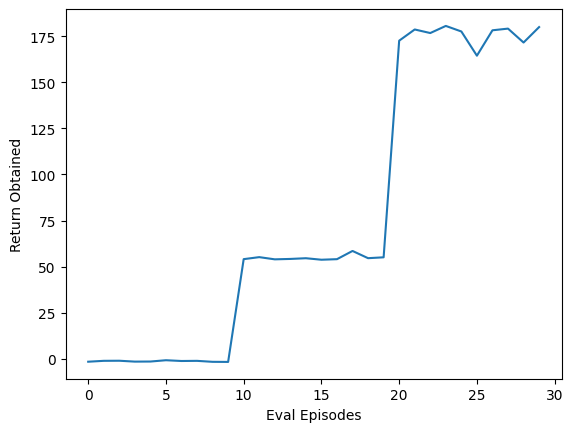

  1%|          | 6178/500000 [00:47<1:06:06, 124.51it/s]


Mean return value of last 10 evaluations = 178.38610949524912


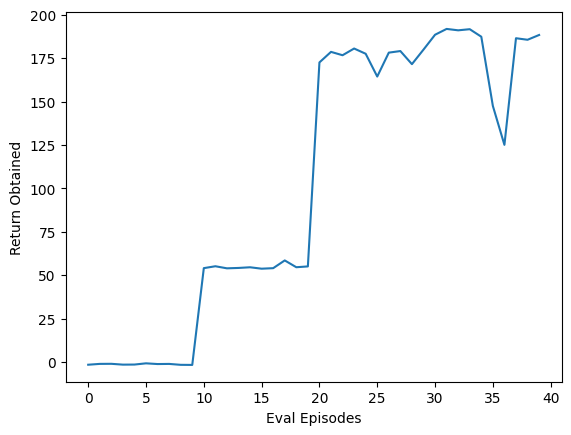

  2%|▏         | 9146/500000 [01:11<1:20:47, 101.27it/s]


Mean return value of last 10 evaluations = 231.55038969840038


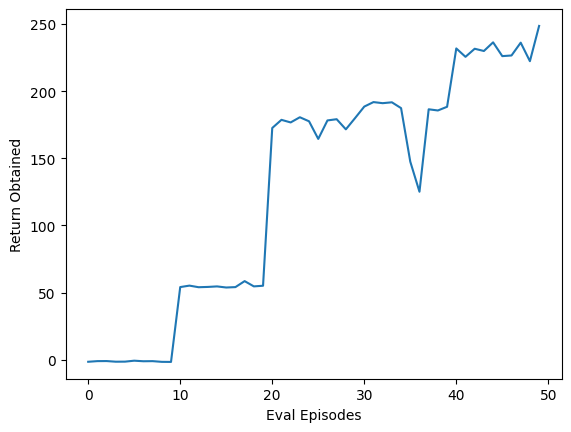

  2%|▏         | 11901/500000 [01:33<1:35:20, 85.33it/s]


Mean return value of last 10 evaluations = 226.73964908235456


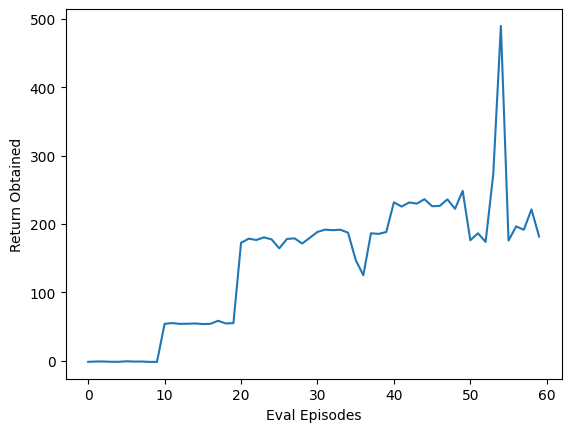

  3%|▎         | 14419/500000 [01:54<58:29, 138.36it/s]


Mean return value of last 10 evaluations = 189.0505563066399


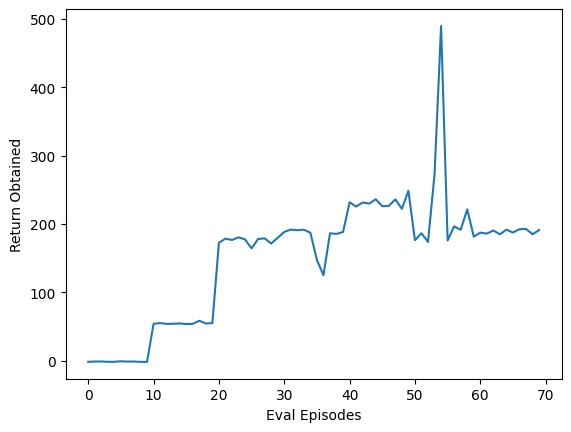

  4%|▎         | 17567/500000 [02:19<59:02, 136.19it/s]


Mean return value of last 10 evaluations = 283.994984804027


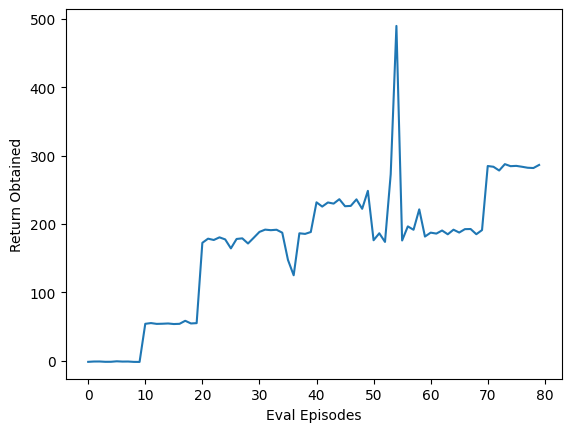

  4%|▍         | 21051/500000 [02:48<1:00:22, 132.23it/s]


Mean return value of last 10 evaluations = 268.5484372240354


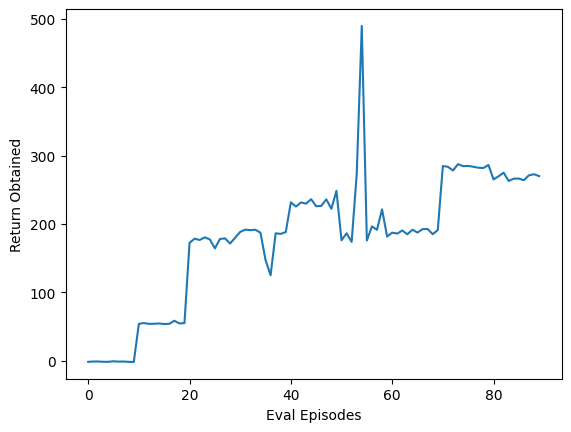

  5%|▍         | 24230/500000 [03:14<58:37, 135.25it/s]


Mean return value of last 10 evaluations = 71.14205051566108


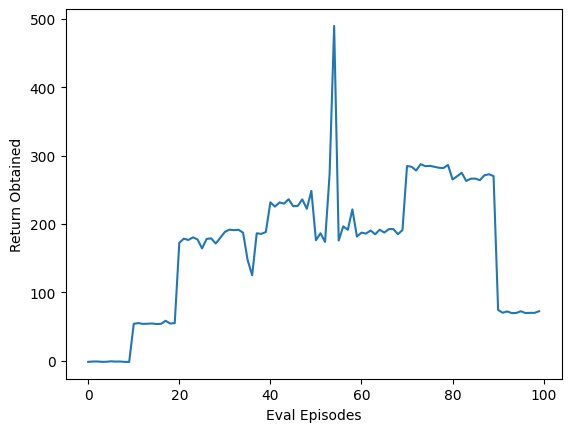

  6%|▌         | 27872/500000 [03:44<1:01:11, 128.60it/s]


Mean return value of last 10 evaluations = 277.1682003043589


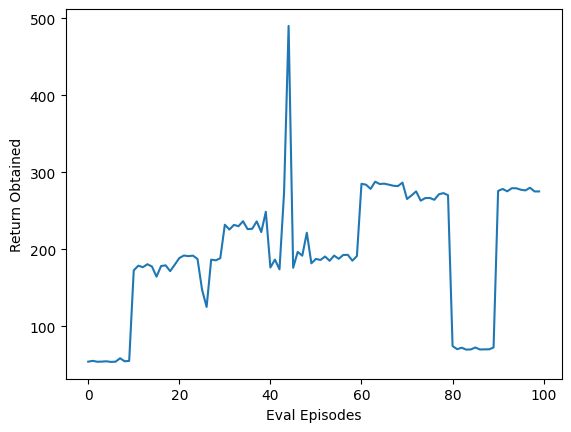

  6%|▋         | 31615/500000 [04:14<56:47, 137.47it/s]


Mean return value of last 10 evaluations = 375.7837379658002


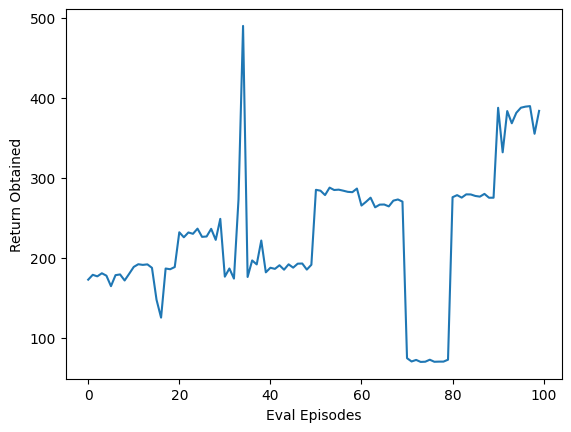

  7%|▋         | 34521/500000 [04:38<57:03, 135.97it/s]


Mean return value of last 10 evaluations = 606.6293472539539


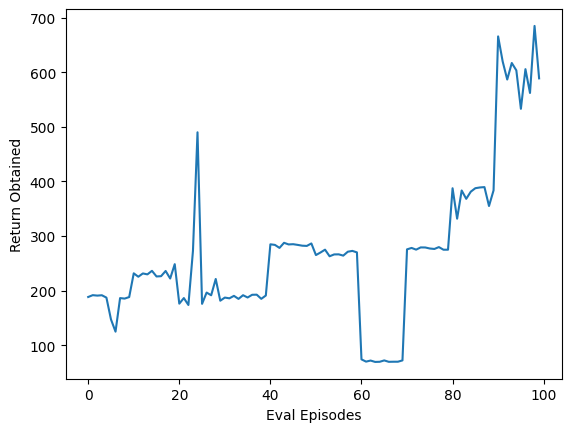

  8%|▊         | 39795/500000 [05:21<57:56, 132.36it/s]


Mean return value of last 10 evaluations = 697.1464252908154


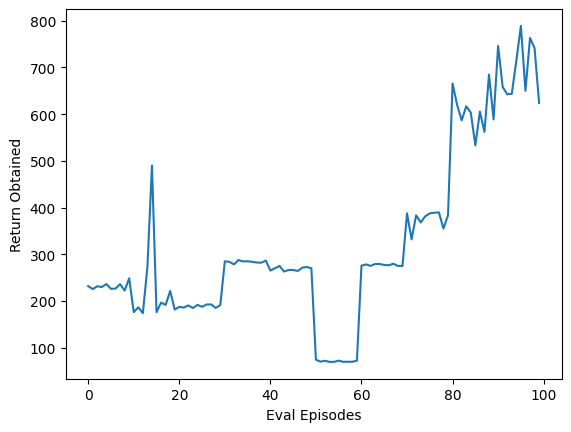

 10%|▉         | 47691/500000 [06:25<1:16:50, 98.11it/s]


Mean return value of last 10 evaluations = 540.6141155746619


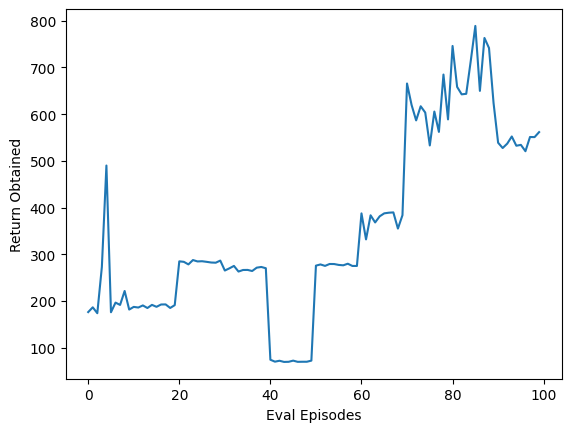

 11%|█         | 52904/500000 [07:08<56:26, 132.02it/s]


Mean return value of last 10 evaluations = 354.2681517001888


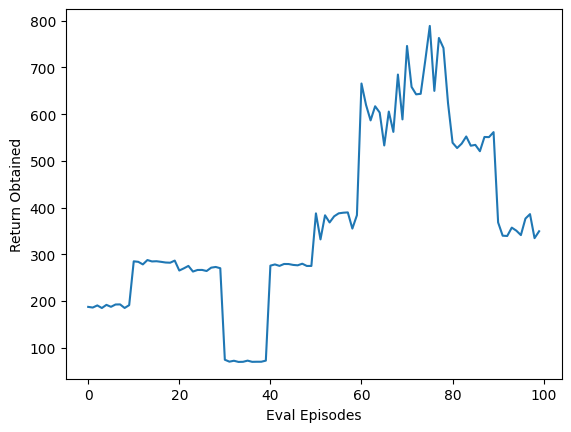

 12%|█▏        | 58224/500000 [07:52<55:55, 131.65it/s]


Mean return value of last 10 evaluations = 608.433164719738


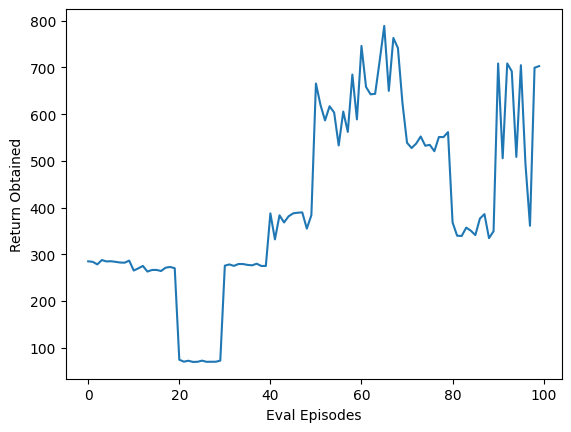

 13%|█▎        | 66268/500000 [09:00<55:54, 129.30it/s]


Mean return value of last 10 evaluations = 960.5377888520583


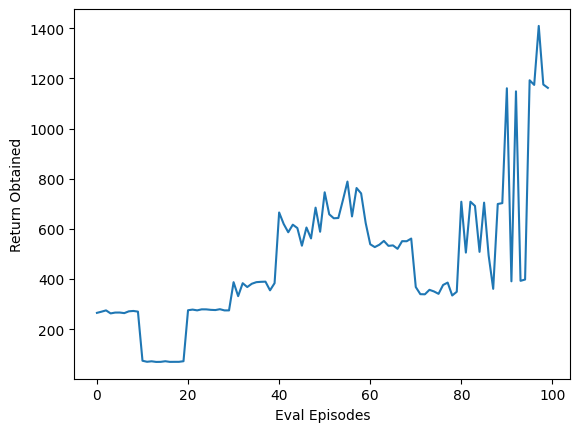

 14%|█▎        | 68666/500000 [09:23<1:19:20, 90.60it/s]


Mean return value of last 10 evaluations = 19.720389366583515


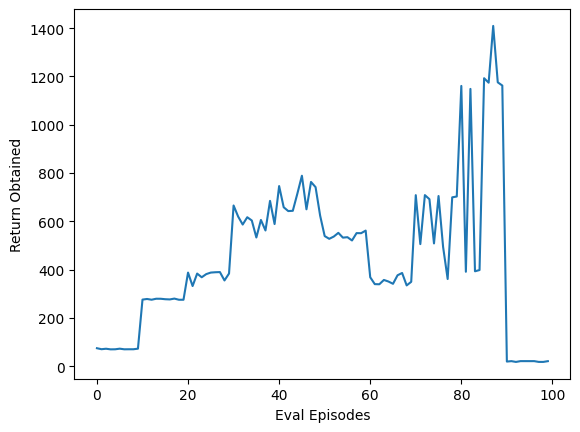

 15%|█▍        | 74106/500000 [10:07<53:53, 131.70it/s]


Mean return value of last 10 evaluations = 857.8990376476406


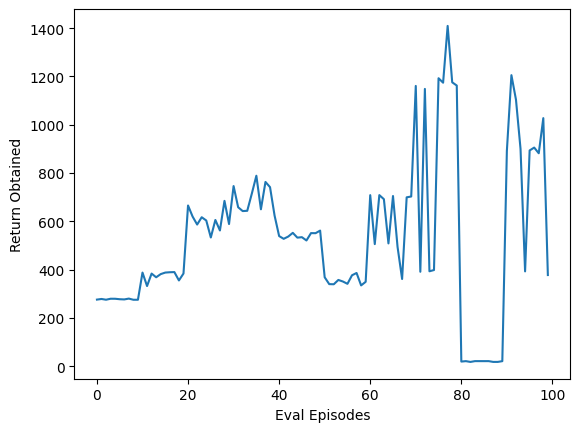

 16%|█▌        | 80730/500000 [11:03<53:25, 130.80it/s]


Mean return value of last 10 evaluations = 2459.915171296093


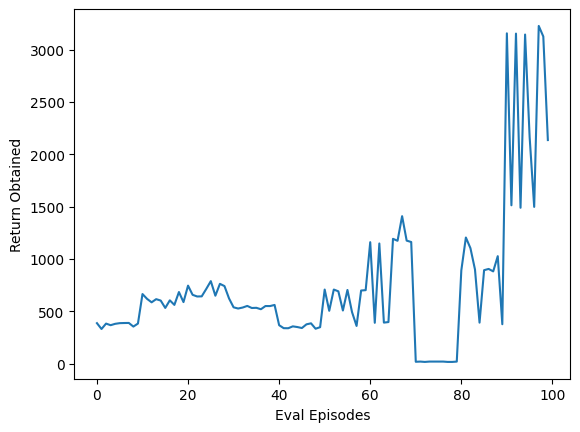

 18%|█▊        | 89354/500000 [12:20<1:10:03, 97.69it/s]


Mean return value of last 10 evaluations = 3216.5423252745013


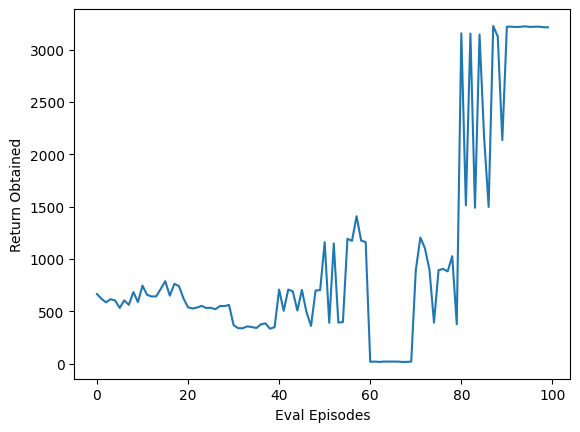

 18%|█▊        | 89355/500000 [12:28<57:18, 119.43it/s] 


In [12]:
ENV = "Hopper-v4"
env = gym.make(ENV)

GAMMA = 0.99
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 64
HIDDEN_DIMS = ((256, 256), (256, 256))
TAU = 5e-3
UPDATE_EVERY = 2
LR = (1e-3, 1e-3)
DECAY_STEPS = int(5e5)
POLICY_NOISE_RATIO = 0.1
POLICY_NOISE_CLIP_RATIO = 0.5
POLICY_OPTIMISE_STEPS = 2
GRAD_CLIP = (1.0, 1.0)

agent = TD3(env, GAMMA, BUFFER_SIZE, BATCH_SIZE, HIDDEN_DIMS, optim.Adam, optim.Adam, GRAD_CLIP, TAU, UPDATE_EVERY, DECAY_STEPS, POLICY_NOISE_RATIO, POLICY_NOISE_CLIP_RATIO, POLICY_OPTIMISE_STEPS, LR)

TIME_STAMPS = int(5e5)
STEP = 30
EVAL = 10
GOAL = 3200
agent.train(TIME_STAMPS, STEP, EVAL, GOAL)
agent.env.close()


Mean return value of last 5 evaluations = 3215.687616974765


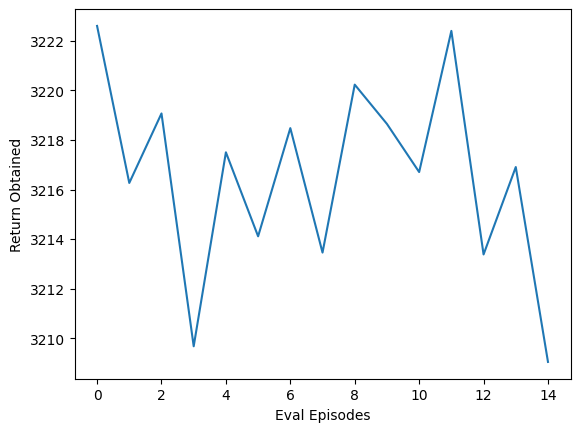

In [20]:
env = gym.make(ENV, render_mode = "rgb_array")
agent.env = env

agent.load_weights("./target_value.pth","./target_policy.pth")
agent.show(5)
agent.env.close()